In [27]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from copy import deepcopy
from tqdm import tqdm
import mne

In [28]:
def cache_mkdir(cache, directory, root_dir='.'):
    """Create directory and return path to it"""
    directory = directory.replace(' ', '_')
    path = os.path.join(root_dir, directory)
    if cache and not os.path.exists(path):
        os.makedirs(path)
    return path

def read_cache(cache, path, silent=False):
    """Read from cache file"""
    result = None
    if cache and os.path.exists(path):
        with open(path, 'rb') as file:
            if not silent:
                print(f'Extracted from cache ({path})')
            result = pickle.load(file)
    return result

def write_cache(cache, obj, path):
    """Write to cache"""
    if cache:
        with open(path, 'wb') as file:
            pickle.dump(obj, file) 

In [29]:
CatBoost=CatBoostClassifier(random_seed=77, logging_level='Silent')
cache=True
cache_dir='cv_fi'
exclude=['sex', 'age', 'education', 'IQ']

cache_mkdir(cache, cache_dir)
cache_file = os.path.join(cache_dir, 'result')

fi = read_cache(cache, cache_file)
if fi is None:
    fi = cv_fi(X,Y,CatBoost)
    write_cache(cache, fi, cache_file)
fi = fi[~fi.index.isin(exclude)]
result=fi

result

Extracted from cache (cv_fi/result)


,split1_fi,split2_fi,split3_fi,split4_fi,split5_fi,split6_fi,split7_fi,split8_fi,split9_fi,split10_fi
AB.A.delta.a.FP1,0.041497,0.050451,0.031934,0.016051,0.035774,0.011956,0.007633,0.046466,0.054553,0.053308
AB.A.delta.b.FP2,0.090171,0.005771,0.121313,0.109282,0.049471,0.070716,0.055776,0.076218,0.075044,0.045541
AB.A.delta.c.F7,0.079956,0.088065,0.078682,0.065594,0.190007,0.062749,0.092443,0.057720,0.102581,0.049680
AB.A.delta.d.F3,0.037381,0.177218,0.064518,0.172925,0.170116,0.194606,0.122551,0.179794,0.070993,0.171911
AB.A.delta.e.Fz,0.195998,0.071015,0.084145,0.109915,0.039621,0.067382,0.029985,0.084351,0.069122,0.049471
...,...,...,...,...,...,...,...,...,...,...
COH.F.gamma.p.P4.r.O1,0.070044,0.058034,0.023736,0.020698,0.013143,0.040190,0.073003,0.067731,0.060213,0.022582
COH.F.gamma.p.P4.s.O2,0.053414,0.054957,0.030687,0.056336,0.022315,0.073037,0.043416,0.048135,0.034430,0.044639
COH.F.gamma.q.T6.r.O1,0.067865,0.053371,0.060403,0.041259,0.063764,0.064288,0.045019,0.041660,0.029789,0.074276
COH.F.gamma.q.T6.s.O2,0.046161,0.088635,0.049072,0.039864,0.006293,0.035032,0.032461,0.019426,0.018177,0.014602


In [30]:
df=pd.DataFrame(result)
df['mean_fi'] = df.mean(axis=1)
importances = df.sort_values(by='mean_fi', ascending=False)

In [31]:
# Initializing a dictionary to store sums for each band-category combination across all splits
psd_fc_split_sums = {
    'Delta PSD': [0] * 10,
    'Theta PSD': [0] * 10,
    'Alpha PSD': [0] * 10,
    'Beta PSD': [0] * 10,
    'Gamma PSD': [0] * 10,
    'Highbeta PSD': [0] * 10,
    'Delta FC': [0] * 10,
    'Theta FC': [0] * 10,
    'Alpha FC': [0] * 10,
    'Beta FC': [0] * 10,
    'Gamma FC': [0] * 10,
    'Highbeta FC': [0] * 10
}

# Iterate over each feature and sum values accordingly for each split
for feature in importances.index:
    split_values = importances.loc[feature, importances.columns[:-1]].values  # Get values for each split (ignoring mean)
    if feature.startswith('AB'):
        if 'delta' in feature:
            psd_fc_split_sums['Delta PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Delta PSD'], split_values)]
        elif 'theta' in feature:
            psd_fc_split_sums['Theta PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Theta PSD'], split_values)]
        elif 'alpha' in feature:
            psd_fc_split_sums['Alpha PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Alpha PSD'], split_values)]
        elif 'beta' in feature:
            psd_fc_split_sums['Beta PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Beta PSD'], split_values)]
        elif 'gamma' in feature:
            psd_fc_split_sums['Gamma PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Gamma PSD'], split_values)]
        elif 'highbeta' in feature:
            psd_fc_split_sums['Highbeta PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Highbeta PSD'], split_values)]
    elif feature.startswith('COH'):
        if 'delta' in feature:
            psd_fc_split_sums['Delta FC'] = [x + y for x, y in zip(psd_fc_split_sums['Delta FC'], split_values)]
        elif 'theta' in feature:
            psd_fc_split_sums['Theta FC'] = [x + y for x, y in zip(psd_fc_split_sums['Theta FC'], split_values)]
        elif 'alpha' in feature:
            psd_fc_split_sums['Alpha FC'] = [x + y for x, y in zip(psd_fc_split_sums['Alpha FC'], split_values)]
        elif 'beta' in feature:
            psd_fc_split_sums['Beta FC'] = [x + y for x, y in zip(psd_fc_split_sums['Beta FC'], split_values)]
        elif 'gamma' in feature:
            psd_fc_split_sums['Gamma FC'] = [x + y for x, y in zip(psd_fc_split_sums['Gamma FC'], split_values)]
        elif 'highbeta' in feature:
            psd_fc_split_sums['Highbeta FC'] = [x + y for x, y in zip(psd_fc_split_sums['Highbeta FC'], split_values)]

# Creating a DataFrame from the dictionary
psd_fc = pd.DataFrame.from_dict(psd_fc_split_sums, orient='index', columns=importances.columns[:-1])
psd_fc['mean']=psd_fc.mean(axis=1)
psd_fc

,split1_fi,split2_fi,split3_fi,split4_fi,split5_fi,split6_fi,split7_fi,split8_fi,split9_fi,split10_fi,mean
Delta PSD,1.394956,1.751471,1.326657,1.640432,2.548605,1.530915,1.291155,1.702195,1.256691,1.335871,1.577895
Theta PSD,2.450068,1.435632,2.623926,1.695908,3.080937,1.863021,1.874834,1.919528,1.340514,2.128051,2.041242
Alpha PSD,0.735389,0.698471,1.122994,0.834150,0.929602,1.066078,1.213549,0.899876,1.088317,1.075060,0.966348
Beta PSD,6.026203,5.829498,10.123759,4.320283,6.473470,5.871047,6.212107,5.061413,2.689908,9.292784,6.190047
Gamma PSD,0.766721,0.920386,0.927748,1.067916,0.696283,0.935108,1.173872,1.007298,0.971996,1.015094,0.948242
Highbeta PSD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Delta FC,16.819737,12.945663,11.863866,12.302763,12.440715,15.423595,13.037378,13.539401,13.806988,12.707741,13.488785
Theta FC,10.433196,8.382699,7.784629,10.185599,8.269977,9.182309,10.490607,9.138883,7.931925,9.690075,9.148990
Alpha FC,12.599634,12.316901,11.003620,13.941307,12.620419,10.004834,13.471728,12.237103,9.371631,13.504133,12.107131
Beta FC,15.029575,16.264295,14.923099,15.763303,14.634271,15.845947,15.881876,15.867789,15.518857,16.515098,15.624411


In [32]:
psd_fc_fi=psd_fc.sort_values(by='mean', ascending=False)
psd_fc_fi=psd_fc_fi.head(10)

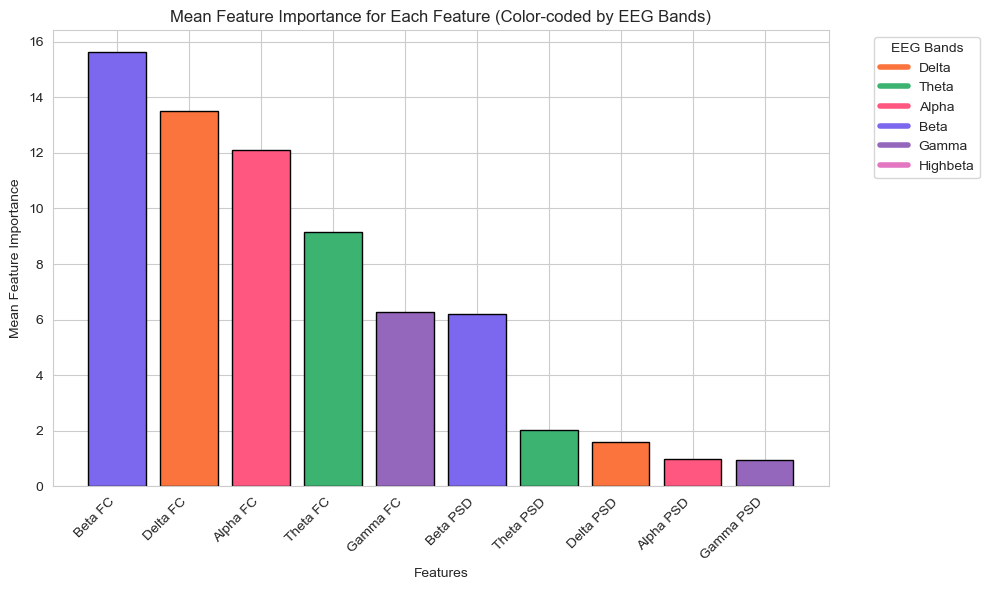

In [33]:
# Assigning colors based on EEG bands
band_colors = {
    'Delta': '#FB743E',    # vibrant blue
    'Theta': '#3cb371',    # vibrant green
    'Alpha': '#FF577F',    # vibrant orange
    'Beta': '#7b68ee',     # vibrant red
    'Gamma': '#9467bd',    # vibrant purple
    'Highbeta': '#e377c2'}

# Determining band for each feature and assigning color
colors = []
for feature in psd_fc_fi.index:
    found = False
    for band, color in band_colors.items():
        if band in feature:
            colors.append(color)
            found = True
            break
    if not found:
        colors.append('grey')


# Plotting the mean values with color coding based on EEG bands
plt.figure(figsize=(10, 6))
plt.bar(psd_fc_fi.index, psd_fc_fi['mean'], color=colors, edgecolor='black')
plt.xlabel('Features')
plt.ylabel('Mean Feature Importance')
plt.title('Mean Feature Importance for Each Feature (Color-coded by EEG Bands)')
plt.xticks(rotation=45, ha='right')


# Adding a legend for all EEG bands, even if not present in the data
legend_labels = [plt.Line2D([0], [0], color=color, lw=4) for color in band_colors.values()]
legend_titles = list(band_colors.keys())
plt.legend(legend_labels, legend_titles, title='EEG Bands', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [34]:
fi=importances.head(10)
print(fi)

                        split1_fi  split2_fi  split3_fi  split4_fi  split5_fi  \
AB.D.beta.m.T5           2.294962   1.558356   3.793390   1.049643   1.570553   
COH.A.delta.e.Fz.f.F4    1.086176   1.595528   0.595003   0.827789   0.324516   
COH.A.delta.c.F7.f.F4    0.539098   0.407278   1.327274   0.223714   0.235558   
COH.A.delta.o.Pz.r.O1    0.919912   0.494237   0.124700   1.164105   0.326967   
AB.D.beta.q.T6           0.374821   0.715316   0.775968   0.321389   0.320324   
COH.A.delta.i.C3.m.T5    1.559532   0.183929   0.107142   0.495486   0.418223   
COH.C.alpha.b.FP2.e.Fz   0.929630   0.268072   0.584624   0.744460   0.728741   
COH.C.alpha.a.FP1.e.Fz   0.371267   0.141177   0.279545   0.677594   0.963773   
COH.B.theta.e.Fz.f.F4    0.741918   0.406489   0.335992   0.985681   0.167253   
COH.C.alpha.a.FP1.n.P3   0.160073   0.939097   0.314552   0.294130   0.334080   

                        split6_fi  split7_fi  split8_fi  split9_fi  \
AB.D.beta.m.T5           2.189837   1.

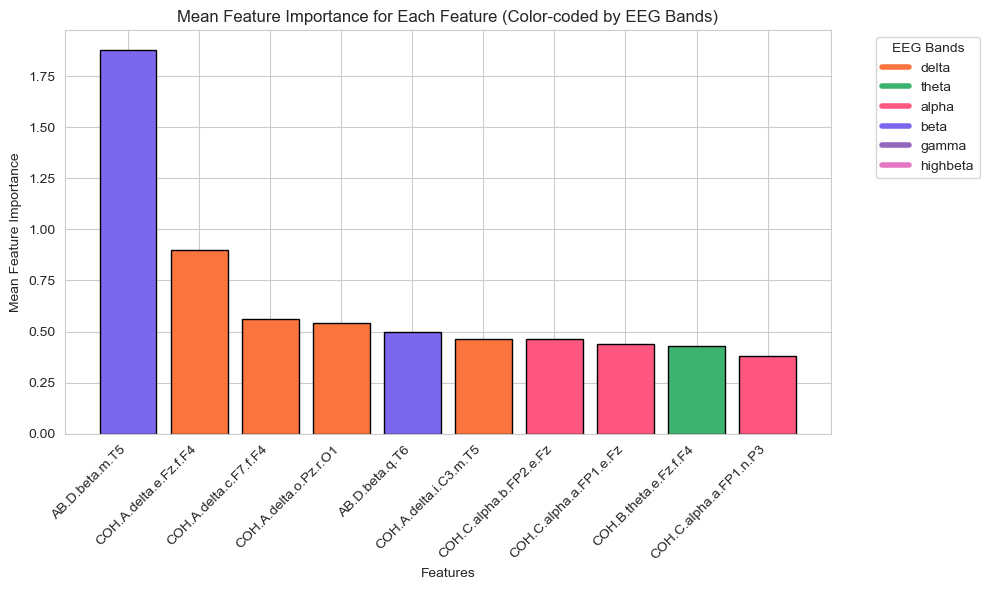

In [35]:

# Assigning colors based on EEG bands
band_colors = {
    'delta': '#FB743E',    # vibrant blue
    'theta': '#3cb371',    # vibrant green
    'alpha': '#FF577F',    # vibrant orange
    'beta': '#7b68ee',     # vibrant red
    'gamma': '#9467bd',    # vibrant purple
    'highbeta': '#e377c2'}

# Determining band for each feature and assigning color
colors = []
for feature in fi.index:
    found = False
    for band, color in band_colors.items():
        if band in feature:
            colors.append(color)
            found = True
            break
    if not found:
        colors.append('grey')


# Plotting the mean values with color coding based on EEG bands
plt.figure(figsize=(10, 6))
plt.bar(fi.index, fi['mean_fi'], color=colors, edgecolor='black')
plt.xlabel('Features')
plt.ylabel('Mean Feature Importance')
plt.title('Mean Feature Importance for Each Feature (Color-coded by EEG Bands)')
plt.xticks(rotation=45, ha='right')


# Adding a legend for all EEG bands, even if not present in the data
legend_labels = [plt.Line2D([0], [0], color=color, lw=4) for color in band_colors.values()]
legend_titles = list(band_colors.keys())
plt.legend(legend_labels, legend_titles, title='EEG Bands', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [36]:
def cv_fi(x, y, model, random_state=None, n=10, debug=True):

    feature_names = x.columns
    cv_results = dict()
    # split counter
    i = 1
    # KFold splitting
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=random_state)
    
    for train_index, test_index in skf.split(x, y):
        # get train x and y
        x_train, y_train = x.iloc[train_index], y.iloc[train_index]
        # scale features
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        # fit model
        model.fit(x_train, y_train)
        # save feature importance
        cv_results[f'split{i}_fi'] = model.feature_importances_
        # debug
        
        if debug:
            # get test x and y
            x_test, y_test = x.iloc[test_index], y.iloc[test_index]
            # scale
            x_test = scaler.transform(x_test)
            # predict
            y_pred = model.predict(x_test)
            # show results
            print(f'Split {i} report')
            print(classification_report(y_test, y_pred))
        # iterate split counter
        i += 1
    result = pd.DataFrame(cv_results, index=feature_names)
    return (result)

def psd_coh(name):
    splt = name.split(sep='.')
    
    if len(splt) < 5:
        result = name
    elif len(splt)==5:
        result = f'{splt[2]} PSD'
    else:
        result = f'{splt[2]} FC'
    return result

def summary_fi_table(table, threshold=0):
    
    # rename index
    table.index.name = 'feature'
    # reset index and convert to long format
    table = table.reset_index().melt(id_vars='feature', var_name='split_id', value_name='importance')
    
    # negative importance?
    n_imp = (table['importance'] < 0).any()
    
    # if importance is above the threshold than survived=1, 0 othervise
    table['survived'] = (table['importance'].abs() > threshold)
    
    # feature category
    table['feature_cat'] = table['feature'].apply(psd_coh)
    
    
    # summary table
    result = table.groupby(['feature_cat', 'feature']).agg({
        'importance': ['sum', 'mean', 'median'],
        'survived': 'mean'
    })
    return result

def flatten_columns(table):
    """Flatten column indices"""
    table.columns = ['_'.join(col) for col in table.columns.values]
    return table

def top_n(table, n=15, col='importance_sum', survival_thres=0.7, abs_based=True):
    """Report n top important features"""
    if abs_based:
        table['abs_col'] = table[col].abs()
        col='abs_col'
    result = table[table['survived_mean'] >= survival_thres].sort_values(col, ascending=False).iloc[:n]
    return result


In [37]:
def barchart(table, x, heights, color=None, ax=None, palette=None, orient='h', xlab=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    if orient == 'v':
        barfunc = ax.bar
        ax.yaxis.grid(True)
        ax.xaxis.grid(False)
        ax.set_xlabel(xlab if xlab else x)
        ax.set_ylabel(ylab if ylab else heights)
    else:
        barfunc = ax.barh
        ax.xaxis.grid(True)
        ax.yaxis.grid(False)
        ax.set_ylabel(xlab if xlab else x)
        ax.set_xlabel(ylab if ylab else heights)
    if color is not None:
        # Handle colors using the feature categories from the palette
        colors = [palette.get(cat, 'grey') for cat in table['feature_cat']]
        patches = [mpatches.Patch(color=palette[c], label=c) for c in set(table['feature_cat']) if c in palette]
        ax.legend(handles=patches, loc='best')
    else:
        colors = None
    barfunc(table[x], table[heights], color=colors)
    return ax

# Ensure consistent coloration
feature_category = [
    'delta PSD',
    'delta FC',
    'theta PSD',
    'theta FC',
    'alpha PSD',
    'alpha FC',
    'beta PSD',
    'beta FC',
    'highbeta PSD',
    'highbeta FC',
    'gamma PSD',
    'gamma FC']
cmap = plt.get_cmap('tab20')
palette = {feature_category[i]: cmap.colors[i] for i in range(len(feature_category))}

# Position of channels on EEG map
chs = {
    'FP1': [-0.2625, 0.6300000000000001],
    'FP2': [0.2625, 0.6300000000000001],
    'F7': [-0.6387499999999999, 0.34125],
    'F3': [-0.35000000000000003, 0.28875],
    'Fz': [0.0, 0.2625],
    'F4': [0.35000000000000003, 0.28875],
    'F8': [0.6387499999999999, 0.34125],
    'T3': [-0.74375, -0.07],
    'C3': [-0.39375, -0.07],
    'Cz': [0.0, -0.07],
    'C4': [0.39375, -0.07],
    'T4': [0.74375, -0.07],
    'T5': [-0.6387499999999999, -0.48125],
    'P3': [-0.35000000000000003, -0.42875],
    'Pz': [0.0, -0.4025],
    'P4': [0.35000000000000003, -0.42875],
    'T6': [0.6125, -0.48125],
    'O1': [-0.2625, -0.77],
    'O2': [0.2625, -0.77]}
channels = pd.DataFrame(chs).transpose()

sns.set_style('whitegrid')

def reformat_name(name):
    '''
    reformat from XX.X.band.x.channel to band.channel or 
    COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2
    '''
    splitted = name.split(sep='.')
    if len(splitted) < 5:
        return name
    if splitted[0] != 'COH':
        result = f'{splitted[2]}.{splitted[4]}'
    else:
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}.{splitted[6]}'
    return result

def extract_channel(feature):
    """
    Extract channels from QEEG feature names
    Examples:
    delta.T4 -> T4
    COH.delta.Cz.T4 -> [Cz, T4]
    """
    feature=reformat_name(feature)
    split = feature.split(sep='.')
    if split[0] == 'COH':
        result = split[4:]
    else:
        result = [split[-1]]
    return result

def get_channels(features):
    """
    Get channels from comma separated feature names.
    Examples:
    delta.T4, COH.delta.Cz.T4 -> [T4, [Cz, T4]]    
    """
    split = features.split(sep=',')
    result = [extract_channel(ftr) for ftr in split]
    return np.concatenate(result)

def get_coordinates(channels_arr):
    """Extract x and y coordinates by channel names"""
    valid_channels = [ch for ch in channels_arr if ch in channels.index]
    selected = channels.loc[valid_channels]
    x, y = selected.iloc[:, 0], selected.iloc[:, 1]
    return x, y

def fi_viz(table, feature, feature_cat, importance, palette, figure=None, cat=True):
    if figure is None:
        figure = plt.figure()
    if cat:
        axes = figure.subplots(1, 2)
        cat_fi = table.groupby(feature_cat)[importance].sum().reset_index().sort_values(importance, ascending=False)
        barchart(cat_fi, feature_cat, importance, feature_cat, axes[1], palette, xlab='importance', ylab='feature category')
    else:
        axes = figure.subplots()
        axes = [axes]        
    barchart(table, feature, importance, feature_cat, axes[0], palette, xlab='importance')        
    return figure


def fi_viz_eeg(table,  palette, feature='feature', feature_cat='feature_cat', figure=None, ax=None, separate=True, img_path='head.png'):
    # Read backgroud image
    im = plt.imread('head.png')
    if ax is not None:
        separate=False
    elif figure is None:
        figure = plt.figure()
    if separate:
        axes = figure.subplots(1, 2)
        ax_psd = axes[0]
        ax_coh = axes[1]
        axes[0].set_title('Power Spectral Density (PSD)')
        axes[1].set_title('Functional Connectivity (FC)')
    else:
        if ax is None:
            axes = figure.subplots()
        else:
            axes = ax
        ax_psd = axes
        ax_coh = axes
        axes = [axes]
    # Plot 
    ftrcat_channels  = table.groupby(feature_cat)[feature].agg(','.join).transform(get_channels)
    for ftr_cat, channels_arr in ftrcat_channels.items():
        color = palette[ftr_cat]
        if 'PSD' in ftr_cat:
            x, y = get_coordinates(channels_arr)
            ax_psd.scatter(x, y, c=[color], s=plt.rcParams['lines.markersize'] ** 3.5, label=ftr_cat)
        else:
            for i, arr in enumerate(channels_arr):
                x, y = get_coordinates(arr)
                if i == 0:
                    lab = ftr_cat
                else:
                    lab = None
                ax_coh.plot(x, y, c=color, linewidth=12, label=lab)
                
    for txt in channels.index:
        for ax in axes:
            text = ax.text(channels.loc[txt, 0], channels.loc[txt, 1], txt, color='white', fontweight='extra bold',  
                           horizontalalignment='center', verticalalignment='center')
            text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])

    for ax in axes:
        ax.imshow(im, extent=[-1, 1, -1, 1])
        ax.axis('off')
        ax.margins(x=0, y=0)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1.5, frameon=False)

def report_fi(result, disorder, col='importance_sum', survival_thres=0.7, palette=palette, root_dir=None):  
    # Extract top n features
    table = top_n(flatten_columns(summary_fi_table(result)), survival_thres=survival_thres).reset_index()

    # Recreate palette to include only relevant colors
    unq_cat = table['feature_cat'].unique()
    palette = {key: item for key, item in palette.items() if key in unq_cat}

    # Barchart feature and category importance 
    fig1 = plt.figure(tight_layout=True, figsize=(15, 5))
    fig1.suptitle(disorder)
    fi_viz(table, 'feature', 'feature_cat', col, palette, fig1)
    fig1.tight_layout()

    # Plot feature importance on EEG map
    fig2 = plt.figure(tight_layout=True, figsize=(15, 7))
    fi_viz_eeg(table, figure=fig2, palette=palette)
    fig2.tight_layout()

    # Save figures if root_dir is provided
    if root_dir:
        fig1.savefig(f"{root_dir}/barchart.png")
        fig2.savefig(f"{root_dir}/eeg_map.png")

    return fig1, fig2